# Setup

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.datasets import load_diabetes
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
from dataclasses import dataclass
from lib.eval.generator import run, returnNames
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import pickle
import json
import pathlib
import os
import time

%load_ext autoreload
%autoreload 2

In [ ]:
data_sets = [
    "blobs", # 0
    "breast_cancer", # 1
    "wine", # 2
    "iris", # 3
    "digits", # 4
    "diabetes", # 5
    "bugfix_testset", # 6
]

data_set = data_sets[1]  # Change this to select a dataset
cf_amount = 100
random_state = 42

match data_set:
    case "blobs":
        nc = 3
        X, true_y = make_blobs(centers=nc, cluster_std=2, n_features=2, n_samples=250, random_state=random_state)
    case "breast_cancer":
        nc = 2
        X, true_y = load_breast_cancer(return_X_y=True)
    case "wine":
        nc = 3
        X, true_y = load_wine(return_X_y=True)
    case "iris":
        nc = 3
        X, true_y = load_iris(return_X_y=True)
    case "digits":
        nc = 10
        X, true_y = load_digits(return_X_y=True)
    case "diabetes":
        nc = 2
        X, true_y = load_diabetes(return_X_y=True)
    case "bugfix_testset":
        nc = 8
        X, true_y = make_blobs(centers=nc, cluster_std=1.5, n_features=2, n_samples=1000, random_state=random_state)
        
X = StandardScaler().fit_transform(X)


random.seed(random_state)

km = KMeans(n_clusters=nc, random_state=random_state)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float


cfs = []
for i in range(cf_amount):
    index = random.randint(0, len(X)-1)
    label = y[index]

    foo = set(range(nc))
    foo.remove(label)
    target = random.choice(list(foo))

    cfs.append(CounterfactualData([], index, target, label))

def pickle_cfs(cf_obj):
    name = cf_obj['name']
    p = pathlib.Path(f'./testdata/cfs/{data_set}/{name}.pkl')
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, 'wb') as f:
        pickle.dump(cf_obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def pickle_res(res_obj, method_name):
    p = pathlib.Path(f'./testdata/eval/{data_set}/{method_name}.pkl')
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, 'wb') as f:
        pickle.dump(res_obj, f, protocol=pickle.HIGHEST_PROTOCOL)

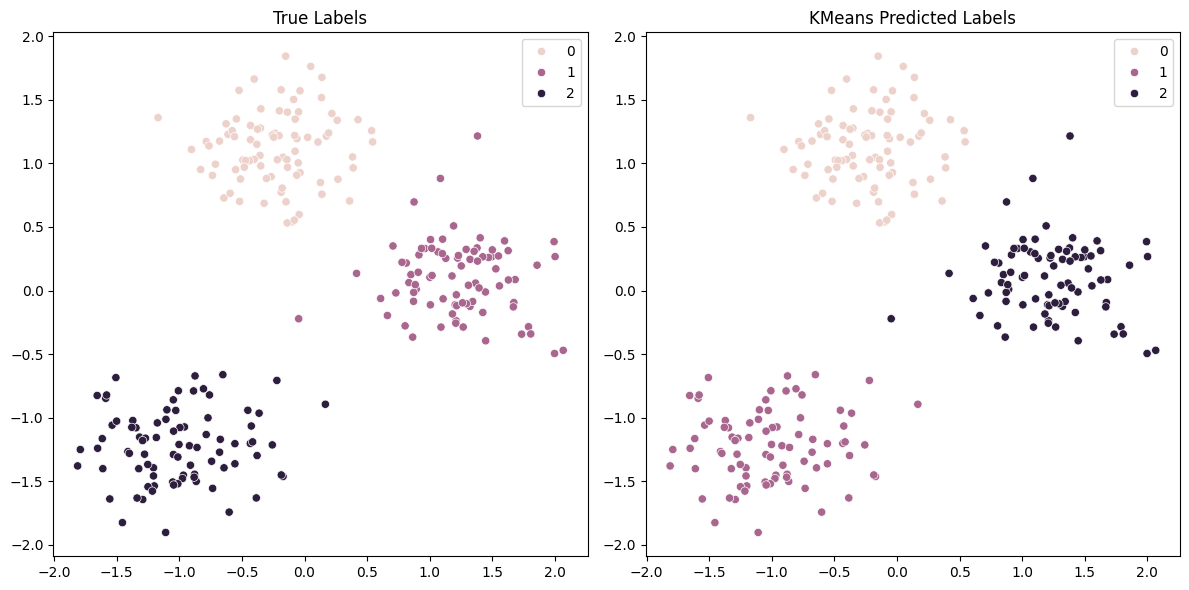

In [3]:
# Plot the data

# plot the clusters
dims = X.shape[1]
if dims > 2:
    pca = PCA(n_components=2)
    embed_X = pca.fit_transform(X)
    
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot with true labels and KMeans labels
if dims > 2:
    print("Using PCA for dimensionality reduction")
    sns.scatterplot(ax=axes[0], x=embed_X[:, 0], y=embed_X[:, 1], hue=true_y, legend='full')
    axes[0].set_title("True Labels")

    sns.scatterplot(ax=axes[1], x=embed_X[:, 0], y=embed_X[:, 1], hue=y, legend='full')
    axes[1].set_title("KMeans Predicted Labels")
else:
    sns.scatterplot(ax=axes[0], x=X[:, 0], y=X[:, 1], hue=true_y, legend='full')
    axes[0].set_title("True Labels")

    sns.scatterplot(ax=axes[1], x=X[:, 0], y=X[:, 1], hue=y, legend='full')
    axes[1].set_title("KMeans Predicted Labels")

plt.tight_layout()
plt.show()

# Cross testing of methods

## Baseline (Baycon)

In [5]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
runtimes = []
for cf in cfs:
    s = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    runtimes.append(time.time() - s)
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

baseLine = {
    "name": "Baseline (BayCon)",
    "counterfactuals": baseline_cfs
}
pickle_cfs(baseLine)

res, _ = run(baseLine, centers, X, y, runtimes)
pickle_res(res, baseLine['name'])

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 28 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (332) CFs (0)
Re-training surrogate model with data size: 332
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (0) Unique overall (0)
Generated random instances: (966)
Predicted top: 20 Counterfactuals: 2
Found new best [-1.28680278  0.78880759  0.21825572 -1.3154443 ], with fitness score 0.4327 (X 0.86542 Y 1.0 F 0.5), oversampling
Known alternatives: 352
Best instance score 0.4327 (X 0.86542 Y 1.0 F 0.5), found on epoch: 1
Re-training surrogate model with data size: 362
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (15) Unique overall (15)
Generated random instances: (706)
Predicted top: 20 Counterfactuals: 20
Found new best [-0.7795133   0.78880759  0.         -1.3

## Baseline (DICE)

In [ ]:
from lib.baseline import baseline_explainer
from lib.dice import dice_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = dice_explainer(10)
baseline_cfs = []
runtimes = []
for cf in cfs:
    s = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    runtimes.append(time.time() - s)
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

baseLine = {
    "name": "Baseline (DiCE)",
    "counterfactuals": baseline_cfs
}
pickle_cfs(baseLine)

res, _ = run(baseLine, centers, X, y, runtimes)
pickle_res(res, baseLine['name'])

Done training classifier. Score: 1.0


100%|██████████| 1/1 [02:52<00:00, 172.41s/it]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [01:26<00:00, 86.37s/it]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [01:26<00:00, 86.75s/it]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [01:27<00:00, 87.12s/it]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [01:26<00:00, 86.44s/it]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [01:26<00:00, 86.24s/it]


Found 10 counterfactuals
Done training classifier. Score: 1.0


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Found 10 counterfactuals
Done training classifier. Score: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

## Baycon - Model Agnostic

In [ ]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['kmeans', 'model_agnostic']
run_mode = modes[1]
runtimes = []

pred = km.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(km.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    s = time.time()
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
    runtimes.append(time.time() - s)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

Baycon = {
    "name": "Baycon - Model Agnostic",
    "counterfactuals": baycon_cfs
}

pickle_cfs(Baycon)

res, _ = run(Baycon, centers, X, y, runtimes)
print(res)
pickle_res(res, Baycon['name'])

--- Executing... Initial Instance: 163 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (597) CFs (74)
Re-training surrogate model with data size: 597
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (18) Unique overall (18)
Generated random instances: (2675)
Predicted top: 20 Counterfactuals: 20
Found new best [ 0.72817634  0.99968408 -0.06037473 -0.2987667   0.43942506 -1.45029009
 -1.33454251  0.30737361 -0.         -0.90645905  0.28212782 -1.21708134
 -0.22894363], with fitness score 0.2165 (X 0.9199 Y 0.34 F 0.69231), oversampling
Known alternatives: 617
Best instance score 0.2165 (X 0.9199 Y 0.34 F 0.69231), found on epoch: 1
Re-training surrogate model with data size: 627
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (57) Unique overall (61)
Generated random instances: (1898)
Predic

## Baycon - Kmeans

In [ ]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['kmeans', 'model_agnostic']
run_mode = modes[0]
runtimes = []

pred = km.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(km.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    s = time.time()
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
    runtimes.append(time.time() - s)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

Baycon = {
    "name": "Baycon - KMeans",
    "counterfactuals": baycon_cfs
}

pickle_cfs(Baycon)

res, _ = run(Baycon, centers, X, y, runtimes)
print(res)
pickle_res(res, Baycon['name'])

--- Executing... Initial Instance: 163 Target: 0 Run: 0 ---
[-0.92607185 -0.39404154 -0.49451676  0.17060184 -0.49171185 -0.07598265
  0.02081257 -0.03353357  0.0582655  -0.90191402  0.46180361  0.27076419
 -0.75384618]
1.547655164829618
5.396417831873102
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (597) CFs (597)
Re-training surrogate model with data size: 597
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (13) Unique overall (13)
Generated random instances: (2659)
Predicted top: 20 Counterfactuals: 20
Found new best [-0.05017396  0.99968408 -0.06037473 -0.2987667   0.43942506 -1.45029009
 -1.33454251  0.30737361 -1.14042959  0.09599166  0.         -1.21708134
 -0.22894363], with fitness score 0.4210 (X 0.97735 Y 0.46666 F 0.92308), oversampling
Known alternatives: 617
Best instance score 0.4210 (X 0.97735 Y 0.46666 F 0.92308), found on epoch

## CFDE

In [ ]:
cfde_cfs = []
amount = 20
runtimes = []
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        s = time.time()
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        runtimes.append(time.time() - s)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde = {
    "name": "CFDE",
    "counterfactuals": cfde_cfs
}

pickle_cfs(cfde)

res, _ = run(cfde, centers, X, y, runtimes)
pickle_res(res, cfde['name'])

Starting on: CFDE
Removing invalid counterfactuals!!!


## CFAE

In [ ]:
cfae_cfs = []
amount = 20
runtimes = []
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        s = time.time()
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        runtimes.append(time.time() - s)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae = {
    "name": "CFAE",
    "counterfactuals": cfae_cfs
}

pickle_cfs(cfae)

res, _ = run(cfae, centers, X, y, runtimes)
pickle_res(res, cfae['name'])

Starting on: CFAE
Removing invalid counterfactuals!!!


## NeighborSearch

In [ ]:
ns_cfs = []
runtimes = []
for cf in cfs:
    s = time.time()
    i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, model=km, instance_index=cf.instance, n=15)
    runtimes.append(time.time() - s)
    ns_cfs.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))

nfs = {
    "name": "NeighborSearch",
    "counterfactuals": ns_cfs
}

pickle_cfs(nfs)

res, _ = run(nfs, centers, X, y,runtimes)
pickle_res(res, nfs['name'])

Starting on: NeighborSearch
Removing invalid counterfactuals!!!


## Dice Mod

In [4]:
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist
from lib.util import sparsity_fix


def runner(eps):
    dice_cfs = []
    runtimes = []
    for cf in cfs:
        instance = X[cf.instance].reshape(1, -1)
        s = time.time()
        gainer = Gainer(centers, X, cf.target, instance, eps=eps)
        dice_cf = np.array([adam_opt(instance, gainer.gain, max_iter=1000, lr=0.1)[0][0]])
        runtimes.append(time.time() - s)
        # print(dice_cf.shape)
        # print([km.predict(cf.reshape(1,-1)) for cf in dice_cf])
        dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

    # centers = km.cluster_centers_
    # dists = np.linalg.norm(dice_cf.reshape(1, -1) - centers, axis=1)
    # print(dists)

    name = f'GradCF (eps={eps})'

    dice_mod = {
        "name": name,
        "counterfactuals": dice_cfs
    }

    pickle_cfs(dice_mod)

    res, _ = run(dice_mod, centers, X, y, runtimes)
    pickle_res(res, dice_mod['name'])

    runtimes_fix = []
    dice_cfs_fixed =  []
    for i,cf in enumerate(dice_cfs):
        s = time.time()
        fixed = sparsity_fix(cf.cf, X[cf.instance, :].reshape(1, -1), X, km)
        runtimes_fix.append(runtimes[i] + (time.time() - s))
        new_cf = CounterfactualData(
            fixed, 
            cf.instance, cf.target, cf.instance_label
        )
        dice_cfs_fixed.append(new_cf)

    dice_mod_sparsity_fix = {
        "name": f"GradCF (eps={eps}) (sparsity fixed)",
        "counterfactuals": dice_cfs_fixed
    }

    pickle_cfs(dice_mod_sparsity_fix)

    res, _ = run(dice_mod_sparsity_fix, centers, X, y, runtimes_fix)
    pickle_res(res, dice_mod_sparsity_fix['name'])

for eps in [0, 0.1, 0.25, 0.5, 0.75, 1]:
    runner(eps)

iter: 161, score: 0.7876810408978077
iter: 490, score: 0.7264383312059489
iter: 505, score: 0.7877515581913361
iter: 203, score: 0.8111426723112639
iter: 436, score: 0.8351222734012245
iter: 481, score: 0.7342989298071105
iter: 474, score: 0.7936157617879437
iter: 436, score: 0.8828825453695003
iter: 313, score: 0.9235728322506831
iter: 476, score: 0.6637371561276486
Starting on: GradCF (eps=0)
Removing invalid counterfactuals!!!
Starting on: GradCF (eps=0) (sparsity fixed)
Removing invalid counterfactuals!!!
iter: 213, score: 0.7697233183375893
iter: 561, score: 0.7039296586233054
iter: 481, score: 0.7713542410315801
iter: 171, score: 0.7904308014883242
iter: 463, score: 0.8125982571995753
iter: 465, score: 0.7117889935262802
iter: 566, score: 0.7772178644149822
iter: 484, score: 0.8664767723490275
iter: 299, score: 0.9115150517288173
iter: 517, score: 0.6473545265040347
Starting on: GradCF (eps=0.1)
Removing invalid counterfactuals!!!
Starting on: GradCF (eps=0.1) (sparsity fixed)
Re

## Dice Mod - Random

In [5]:
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist
import torch

dice_cfs = []
count = 10
runtimes = []
torch.manual_seed(42)

for cf in cfs:
    instance = X[cf.instance].reshape(1, -1)
    s = time.time()
    gainer = Gainer(centers, X, cf.target, instance, eps=0)
    dice_cf = np.array([random_opt(instance, gainer.gain)[0][0]  for _ in range(count)])
    runtimes.append(time.time() - s)
    print(dice_cf.shape)
    print([km.predict(cf.reshape(1,-1)) for cf in dice_cf])
    dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

# centers = km.cluster_centers_
# dists = np.linalg.norm(dice_cf.reshape(1, -1) - centers, axis=1)
# print(dists)

dice_mod = {
    "name": "dice_mod_random",
    "counterfactuals": dice_cfs
}

pickle_cfs(dice_mod)

res, _ = run(dice_mod, centers, X, y, runtimes)
pickle_res(res, dice_mod['name'])

iter: 132, score: 0.7525736479434281
iter: 134, score: 0.7514664377565043
iter: 132, score: 0.7505540005138235
iter: 128, score: 0.7511040936552515
iter: 134, score: 0.7511921594923168
iter: 129, score: 0.7524024545303144
iter: 127, score: 0.7513872809964136
iter: 128, score: 0.7507741479978419
iter: 125, score: 0.7506519412139205
iter: 138, score: 0.7518290417074732
(10, 4)
[array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32)]
iter: 126, score: 0.7041816937878163
iter: 134, score: 0.7033652792394257
iter: 138, score: 0.7031013325965235
iter: 130, score: 0.7035322928049412
iter: 144, score: 0.702527819824919
iter: 131, score: 0.703682619128711
iter: 135, score: 0.7028917112526739
iter: 138, score: 0.7031307047327119
iter: 130, score: 0.6958291204572693
iter: 127, score: 0.7027884451695222
(10

## threshold tree / imm

In [4]:
from lib.tgcf_dtc import TGCF_dtc
from lib.tgcf_imm import TGCF_imm
from lib.util import sparsity_fix


tt_dtc_cfs = []
runtimes_dtc = []

tt_dtc_prime_cfs = []
runtimes_prime_dtc = []

tt_imm_cfs = []
runtimes_imm = []

tt_imm_prime_cfs = []
runtimes_prime_imm = []

tt_rf_cfs = []
runtimes_rf = []

tt_dtc_tree_cfs = []
runtimes_dtc_tree = []

tt_prime_dtc_tree_cfs = []
runtimes_prime_dtc_tree = []

# -------------------------------------------------------------------------
# Threshold Tree DTC

tgcf_dtc = TGCF_dtc(km, centers, X, y)
s = time.time()
tgcf_dtc.fit(False)
dtc_train_time = time.time() - s
print(f"dtc train time: {dtc_train_time}")
for cf in cfs:
    # DTC
    s = time.time()
    tt_cf = tgcf_dtc.find_counterfactuals(X[cf.instance], cf.target, False)
    runtimes_dtc.append(time.time() - s)
    cf_data = CounterfactualData(tt_cf, cf.instance, cf.target, cf.instance_label)
    tt_dtc_cfs.append(cf_data)

    # Plausibility Fix
    s = time.time()
    tt_cf_prime = tgcf_dtc.plausibility_fix(tt_cf, X[cf.instance], cf.target)
    runtimes_prime_dtc.append(runtimes_dtc[-1] + time.time() - s)
    cf_data = CounterfactualData(tt_cf_prime, cf.instance, cf.target, cf.instance_label)
    tt_dtc_prime_cfs.append(cf_data)

runtimes_dtc[0] += dtc_train_time
runtimes_prime_dtc[0] += dtc_train_time

tt_dtc = {
    "name": "TGCF_DTC",
    "counterfactuals": tt_dtc_cfs
}
pickle_cfs(tt_dtc)

res, _ = run(tt_dtc, centers, X, y, runtimes_dtc)
pickle_res(res, tt_dtc['name'])

tt_dtc_prime = {
    "name": "TGCF_DTC'",
    "counterfactuals": tt_dtc_prime_cfs
}
pickle_cfs(tt_dtc_prime)

res, _ = run(tt_dtc_prime, centers, X, y, runtimes_prime_dtc)
pickle_res(res, tt_dtc_prime['name'])

# -------------------------------------------------------------------------
# Threshold Tree DTC Fidelity

tgcf_dtc_fidelity = TGCF_dtc(km, centers, X, y)
s = time.time()
tgcf_dtc_fidelity.fit(True)
dtc_train_time = time.time() - s
print(f"dtc (FIDELITY) train time: {dtc_train_time}")
for cf in cfs:
    # DTC Fidelity
    s = time.time()
    tree_cfs = tgcf_dtc_fidelity.find_counterfactuals(X[cf.instance], cf.target, True)
    runtimes_dtc_tree.append(time.time() - s)
    cf_data = CounterfactualData(tree_cfs, cf.instance, cf.target, cf.instance_label)
    tt_dtc_tree_cfs.append(cf_data)

    # Plausibility Fix
    s = time.time()
    tree_cfs_prime = tgcf_dtc_fidelity.plausibility_fix(tree_cfs, X[cf.instance], cf.target)

    # Apply sparsity fix to each counterfactual in the list
    for i, temp_cf in enumerate(tree_cfs_prime):
        tree_cfs_prime[i] = sparsity_fix(temp_cf.reshape(1,-1), X[cf.instance, :].reshape(1, -1), X, km)

    runtimes_prime_dtc_tree.append(runtimes_dtc_tree[-1] + time.time() - s)
    cf_data = CounterfactualData(tree_cfs_prime, cf.instance, cf.target, cf.instance_label)
    tt_prime_dtc_tree_cfs.append(cf_data)

runtimes_dtc_tree[0] += dtc_train_time
runtimes_prime_dtc_tree[0] += dtc_train_time

tt_dtc_tree = {
    "name": "TGCF_DTC_Fidelity",
    "counterfactuals": tt_dtc_tree_cfs
}
pickle_cfs(tt_dtc_tree)

res, _ = run(tt_dtc_tree, centers, X, y, runtimes_dtc_tree)
pickle_res(res, tt_dtc_tree['name'])

tt_prime_dtc_tree = {
    "name": "TGCF_DTC_Fidelity'",
    "counterfactuals": tt_prime_dtc_tree_cfs
}
pickle_cfs(tt_prime_dtc_tree)

res, _ = run(tt_prime_dtc_tree, centers, X, y, runtimes_prime_dtc_tree)
pickle_res(res, tt_prime_dtc_tree['name'])

# -------------------------------------------------------------------------
# Threshold Tree IMM

tgcf_imm = TGCF_imm(km, centers, X, y)
s = time.time()
tgcf_imm.fit()
imm_train_time = time.time() - s
print(f"IMM train time: {imm_train_time}")
for cf in cfs:
    # IMM
    s = time.time()
    tt_imm_cf = tgcf_imm.find_counterfactuals(X[cf.instance], cf.target)
    runtimes_imm.append(time.time() - s)
    cf_data = CounterfactualData(tt_imm_cf, cf.instance, cf.target, cf.instance_label)
    tt_imm_cfs.append(cf_data)

    # Plausibility Fix
    s = time.time()
    tt_imm_cf_prime = tgcf_imm.plausibility_fix(tt_imm_cf, X[cf.instance], cf.target)
    runtimes_prime_imm.append(runtimes_imm[-1] + time.time() - s)
    cf_data = CounterfactualData(tt_imm_cf_prime, cf.instance, cf.target, cf.instance_label)
    tt_imm_prime_cfs.append(cf_data)

runtimes_imm[0] += imm_train_time
runtimes_prime_imm[0] += imm_train_time

tt_imm = {
    "name": "TGCF_IMM",
    "counterfactuals": tt_imm_cfs
}
pickle_cfs(tt_imm)

res, _ = run(tt_imm, centers, X, y, runtimes_imm)
pickle_res(res, tt_imm['name'])

tt_imm_prime = {
    "name": "TGCF_IMM'",
    "counterfactuals": tt_imm_prime_cfs
}
pickle_cfs(tt_imm_prime)

res, _ = run(tt_imm_prime, centers, X, y, runtimes_prime_imm)
pickle_res(res, tt_imm_prime['name'])


DTC accuracy: 1.0
dtc train time: 0.009913206100463867
Starting on: TGCF_DTC
Removing invalid counterfactuals!!!
Starting on: TGCF_DTC'
Removing invalid counterfactuals!!!
DTC accuracy: 1.0
dtc (FIDELITY) train time: 0.008667707443237305
Starting on: TGCF_DTC_Fidelity
Removing invalid counterfactuals!!!
Starting on: TGCF_DTC_Fidelity'
Removing invalid counterfactuals!!!
IMM train time: 0.004458427429199219
Starting on: TGCF_IMM
Removing invalid counterfactuals!!!
Starting on: TGCF_IMM'
Removing invalid counterfactuals!!!


# Loading method counterfactuals

In [5]:
methods_to_analyze = [] # Runs all methods when empty

methods = []
base_path = f'./testdata/cfs/{data_set}'
for p in os.listdir(base_path):
    with open(os.path.join(base_path, p), 'rb') as file:
        cf_obj = pickle.load(file)
        if cf_obj['name'] not in methods_to_analyze and methods_to_analyze != []:
            continue
        methods.append(cf_obj)

methodNames = [m['name'] for m in methods]
print('\n'.join(sorted(methodNames)))

results = {}
base_path = f'./testdata/eval/{data_set}'
for m in methods:
    with open(os.path.join(base_path, f"{m['name']}.pkl"), 'rb') as handle:
        res = pickle.load(handle)
        results[m['name']] = res

Baseline (BayCon)
Baseline (DiCE)
Baycon - KMeans
Baycon - Model Agnostic
CFAE
CFDE
GradCF (eps=0)
GradCF (eps=0) (sparsity fixed)
GradCF (eps=0.1)
GradCF (eps=0.1) (sparsity fixed)
GradCF (eps=0.25)
GradCF (eps=0.25) (sparsity fixed)
GradCF (eps=0.5)
GradCF (eps=0.5) (sparsity fixed)
GradCF (eps=0.75)
GradCF (eps=0.75) (sparsity fixed)
GradCF (eps=1)
GradCF (eps=1) (sparsity fixed)
NeighborSearch
TGCF_DTC
TGCF_DTC'
TGCF_DTC_Fidelity
TGCF_DTC_Fidelity'
TGCF_IMM
TGCF_IMM'
dice_mod_random


In [6]:
# for m in methods:
#     print(f"Method: {m['name']}")

#     prev_res = results[m['name']]
#     # print(prev_res)
#     print(f"len: {len(prev_res)}")
#     print(f"len 0: {len(prev_res[0])}")
#     prev_runtimes = [r[7] for r in prev_res]
#     print(f"Prev Runtime: {np.array(prev_runtimes).mean():.2f} seconds")

#     new_res, _ = run(m, centers, X, y, prev_runtimes)
#     results[m['name']] = new_res

#     new_runtimes = [r[7] for r in new_res]
#     print(f"New Runtime: {np.array(new_runtimes).mean():.2f} seconds")

#     pickle_res(new_res, m['name'])


#     print("".join('=' for _ in range(50)))

# Print & plot evaluation results

In [14]:
max_name_length = max(len(m) for m in methodNames)
mean_results = []

metrics_active = ["Similarity", "Sparsity", "Plausibility", "Validity", "Diversity", "Runtime", "PercentExplained", "ValidCFs"] # Uses all metrics when empty
# metrics_active = [] # Uses all metrics when empty

def rep(m):
    return m
    return m.replace("-", "_").replace(" ", "_")

for i, n in enumerate(returnNames()):
    if n not in metrics_active and metrics_active != []:
        continue
    row = {}
    for m in methodNames:
        # Get the results for the current method m and metric i
        # so res = list of results, one number for each cf for each instance we're explaining

        # print(f"i: {i}, m: {m}, n: {n}")
        res = [row[i] for row in results[m]]

        flat = []
        for metric in res:
            # if m == "ThresholdTree_fidelity_Tree_Fix": print(n, metric)
            try:
                flat.extend(metric)
            except TypeError:

                # Invalidation and correction metrics return None if no valid/invalid CFs were found
                # Same thing for diversity if given only a single CF
                if metric is None:
                    continue
                flat.append(metric)

        if any(np.isnan(x) for x in flat):
            print(f"Warning: NaN values found in results for method '{m}' and metric '{n}'.")
            print("Filtering them out...")
            print(f"Before filtering: {len(flat)} values")
            flat = [x for x in flat if not np.isnan(x)]
            print(f"After filtering: {len(flat)} values")

        if len(flat) == 0:
            print(f"Warning: No valid results found for method '{m}' and metric '{n}'.")
            row[rep(m)] = "N/A"
            continue

        if n == "Diversity" and "gradcf" in m.lower():
            # GradCF returns only a single CF, so diversity does not make sense
            row[rep(m)] = "N/A"
            continue
        
        try:
            mean = np.mean(flat)
        except ValueError as e:
            print(f"METHOD: {m}, METRIC: {n}")
            print('\n'.join([str(f) for f in flat]))
            raise e
        var = np.var(flat)
        stddev = np.std(flat)
        if n == "PercentExplained":
            row[rep(m)] = f"{mean:.2f}"
        else:
            row[rep(m)] = f"{mean:.2f} ± {stddev:.2f}"

    mean_results.append(row)

base_filter = [rep(m) for m in methodNames]
dice_filter = [rep(m) for m in methodNames if "GradCF (eps=0) (sparsity fixed)" in m]
tree_filter = [rep(m) for m in methodNames if "tgcf" in m.lower()]
it_filter = [rep(m) for m in ["CFAE", "NeighborSearch"]]
existing_filter = [rep(m) for m in ["Baseline (BayCon)", "Baseline (DiCE)", "Baycon - KMeans", "Baycon - Model Agnostic"]]

chosen_filter = [
    'Baseline (DiCE)',
    'Baseline (BayCon)',
    'Baycon - Model Agnostic',
    'Baycon - KMeans',
    'GradCF (eps=0) (sparsity fixed)',
    'CFAE',
    'NeighborSearch',
    "TGCF_DTC_Fidelity'"
]

filter = tree_filter

filter.sort()
print('\n'.join(filter))
if metrics_active == []:
    names = returnNames()
else:
    names = metrics_active

if "ValidCFs" in names:
    validcfs_index = names.index("ValidCFs")
    names[validcfs_index] = "# Valid CFs"

if "PercentExplained" in names:
    validcfs_index = names.index("PercentExplained")
    names[validcfs_index] = "% Explained"


filter_1 = chosen_filter[:4]
filter_2 = chosen_filter[4:]


mean_results_df = pd.DataFrame(mean_results, index=names)
mean_results_df[filter].to_csv(f"{data_set}_tgcf.csv", index=True)
mean_results_df[filter]

TGCF_DTC
TGCF_DTC'
TGCF_DTC_Fidelity
TGCF_DTC_Fidelity'
TGCF_IMM
TGCF_IMM'


TGCF_DTC     TGCF_DTC' TGCF_DTC_Fidelity TGCF_DTC_Fidelity'  \
Similarity     1.54 ± 0.43   1.78 ± 0.50       1.69 ± 0.47        1.89 ± 0.52   
Sparsity       0.00 ± 0.00   0.00 ± 0.00       0.00 ± 0.00        0.30 ± 0.25   
Plausibility  -1.75 ± 0.52  -1.43 ± 0.59      -1.66 ± 0.39       -1.39 ± 0.52   
Validity       0.40 ± 0.49   0.60 ± 0.49       0.81 ± 0.39        0.97 ± 0.17   
Diversity      1.06 ± 0.05   1.07 ± 0.03       0.96 ± 0.20        0.76 ± 0.35   
Runtime        0.00 ± 0.00   0.00 ± 0.00       0.00 ± 0.00        0.00 ± 0.00   
% Explained           0.52          0.77              1.00               1.00   
# Valid CFs    0.53 ± 0.52   0.79 ± 0.45       1.36 ± 0.48        1.62 ± 0.49   

                  TGCF_IMM     TGCF_IMM'  
Similarity     1.01 ± 0.21   1.79 ± 0.45  
Sparsity       0.50 ± 0.00   0.39 ± 0.21  
Plausibility  -2.05 ± 0.44  -1.68 ± 0.73  
Validity       0.16 ± 0.37   0.88 ± 0.32  
Diversity      1.07 ± 0.01   1.07 ± 0.01  
Runtime        0.00 ± 0.00   0.00 ± 0.00  
% Explained           0.16          0.88  
# Valid CFs    0.16 ± 0.37   0.88 ± 0.32

# Plots

cfs in method GradCF : 100
cfs in method CFAE : 1999
cfs in method NeCS : 1500
cfs in method TGCF : 162


/tmp/ipykernel_26972/3055470178.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_26972/3055470178.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")


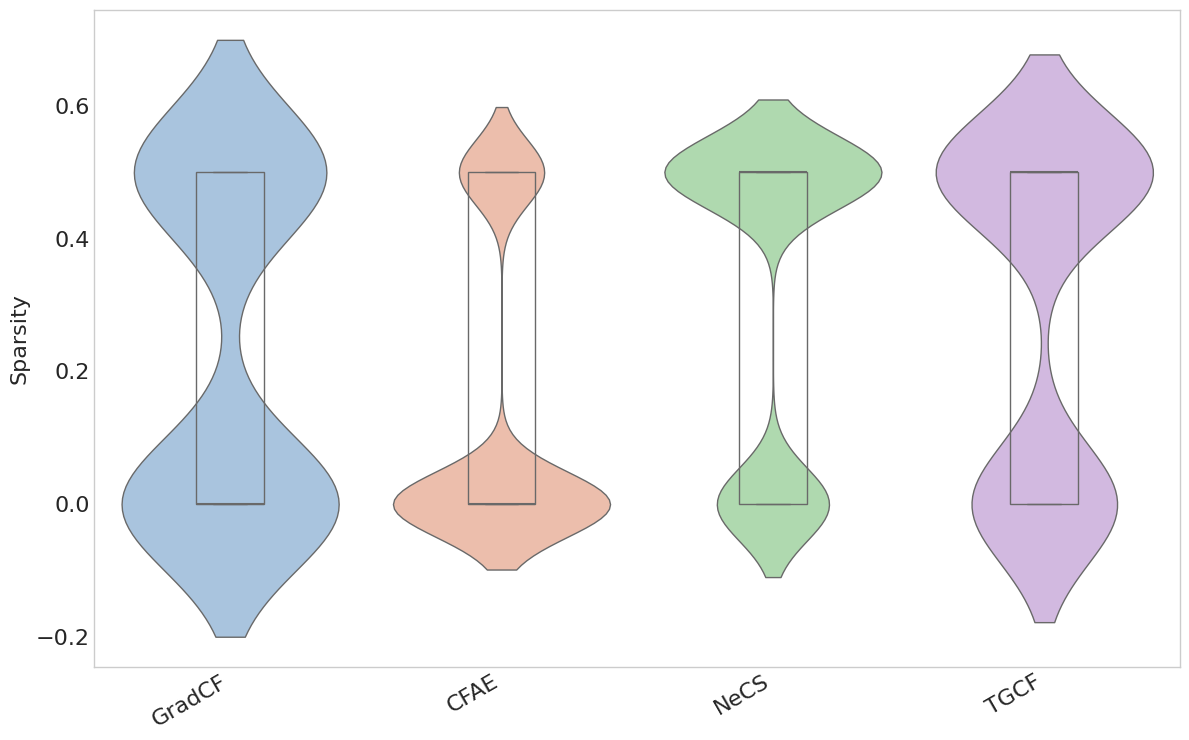

In [8]:
metrics = ["Similarity", "Sparsity", "Plausibility", "Validity", "Diversity", "Invalidation","Correction", "Runtime", "PercentExplained", "ValidCFs"]
metric_index = 1

temp_method_names = ["GradCF", "CFAE", "NeCS", "TGCF"]
filter_violin = ['GradCF (eps=0) (sparsity fixed)', 'CFAE', 'NeighborSearch', "TGCF_DTC_Fidelity'"]

temp_results = [results[filter_violin[i]] for i in range(len(filter_violin))]


all_similarities = [np.concatenate([temp_results[j][i][metric_index] for i in range(len(temp_results[0]))]) for j in range(len(temp_results))]

for i in range(len(all_similarities)):
    print(f"cfs in method", temp_method_names[i], ":", len(all_similarities[i]))

 
vals = np.concatenate([all_similarities[i] for i in range(len(all_similarities))])
labels = []
for i in range(len(temp_method_names)):
    labels += [temp_method_names[i]] * len(all_similarities[i])

# Create a Pandas DataFrame
df = pd.DataFrame({
    metrics[metric_index]: vals,
    'Category': labels
})
 
# Approximate colors from your example plot for the violins
palette_colors = ["#a0c4e7", "#f7b9a1", "#a8e0a8", "#d4b3e6"] # light blue, light orange, light green
 
# Define colors and linewidths for boxplot elements and violin outlines
median_color = 'dimgray'
outline_color = 'dimgray' # For box, whiskers, caps, and violin edges
median_linewidth = 1.5
outline_linewidth = 1.0
 
# Set a style for the plot (optional, but can provide a good base)
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style
 
# Create the figure and axes explicitly
fig, ax = plt.subplots(figsize=(12, 7.5))
 
# 1. Draw the violin plots
#    - inner=None because we will draw a custom boxplot on top.
#    - Pass 'ax' to ensure plotting on the correct axes.
sns.violinplot(
    x='Category',
    y=metrics[metric_index],  # Use the metric index to select the correct metric
    data=df,
    palette=palette_colors,
    inner=None,  # Crucial: We'll draw our own boxplot
    linewidth=outline_linewidth,    # Linewidth for the violin outline
    edgecolor=outline_color,        # Color for the violin outline
    ax=ax
)
 
# 2. Overlay the box plots with custom styling
#    - Make the boxplot narrower to fit nicely inside the violins.
#    - showfliers=False to hide outlier markers if any.
#    - Pass 'ax' to plot on the same axes.
#    - Use the ...props arguments here, where they are valid.
sns.boxplot(
    x='Category',
    y=metrics[metric_index],  # Use the metric index to select the correct metric
    data=df,
    width=0.25,  # Adjust this width to control how wide the box is within the violin
    showfliers=False,
    ax=ax,
    # --- Styling for the boxplot elements ---
    # Box (IQR) properties: transparent face, gray edge
    boxprops={'facecolor': 'none', 'edgecolor': outline_color, 'linewidth': outline_linewidth},
    # Median line properties
    medianprops={'color': median_color, 'linewidth': median_linewidth},
    # Whisker properties
    whiskerprops={'color': outline_color, 'linewidth': outline_linewidth},
    # Cap properties (the lines at the end of whiskers)
    capprops={'color': outline_color, 'linewidth': outline_linewidth}
    # Note: For boxplot, 'palette' is not needed here if 'facecolor' is 'none'
    # and line colors are explicitly set.
)
 
# Further plot customizations to match your example's appearance
ax.set_ylabel(metrics[metric_index], fontsize=16)
ax.set_xlabel("")  # No x-axis label in the example
 
# Customize x-axis tick labels
ax.tick_params(axis='x', labelsize=16) # Set font size for x-ticks
# Get current tick labels for rotation and alignment
# Ensure x-ticks are set before getting labels
# current_xticks = ax.get_xticks()
# ax.set_xticks(current_xticks) # Re-set them to ensure they are fixed
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
 
 
# Customize y-axis tick labels
ax.tick_params(axis='y', labelsize=16)
 
# Set y-axis limits
# ax.set_ylim(0, 1.1)
 
# Ensure no background grid lines are visible (overriding the style's grid)
ax.grid(False)
 
# Adjust layout to make sure everything fits without overlapping
plt.tight_layout()
 
# Show the plot
plt.show()

In [9]:
def plot(f1, f2, methodNames, results, names, plt_index):
    for m in methodNames:
        res = results[m]
        result_x = [row[f1] for row in res]
        result_y = [row[f2] for row in res]

        plt.scatter(result_x[plt_index], result_y[plt_index], label=f"{m}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

def filter_nested_list(data_list, truth_array):
    filtered_list = []
    for i in range(len(data_list)):
        current_sublist = data_list[i]
        current_truth_sublist = truth_array[i]
        
        new_sublist = []
        for j in range(len(current_sublist)):
            if current_truth_sublist[j]:
                new_sublist.append(current_sublist[j])
        filtered_list.append(new_sublist)
        
    return filtered_list

def bigPlot(f1, f2, methodNames, results, names):
    for m in methodNames:
        res = results[m]

        results_val = [row[3] for row in res]

        result_x = [row[f1] for row in res]
        result_y = [row[f2] for row in res]

        result_x = filter_nested_list(result_x, results_val)
        result_y = filter_nested_list(result_y, results_val)

        all_x = []
        all_y = []
        for i in range(len(result_x)):
            all_x.extend(result_x[i])
            all_y.extend(result_y[i])

        plt.scatter(all_x, all_y, label=f"{m}",s=13, alpha=0.7)

    # Adding title and labels
    plt.title(f"Scatter plot of Dissimilarity vs {names[f2]}")
    plt.xlabel(f"Result Dissimilarity")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend(frameon=True)
    plt.show()

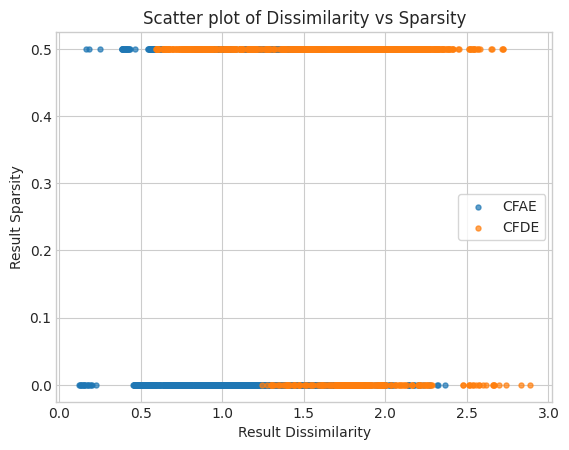

In [10]:
for i in range(0):
    plot(0,2, methodNames, results, returnNames(), plt_index=i)

bigPlot(0, 1, ['CFAE','CFDE'], results, returnNames())

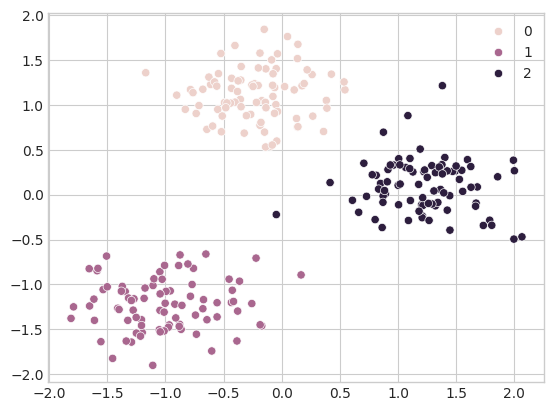

In [11]:
pca = PCA(n_components=2)
if X.shape[1] > 2:
    embed_X = pca.fit_transform(X)
else:
    embed_X = X
    
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
plt.show()

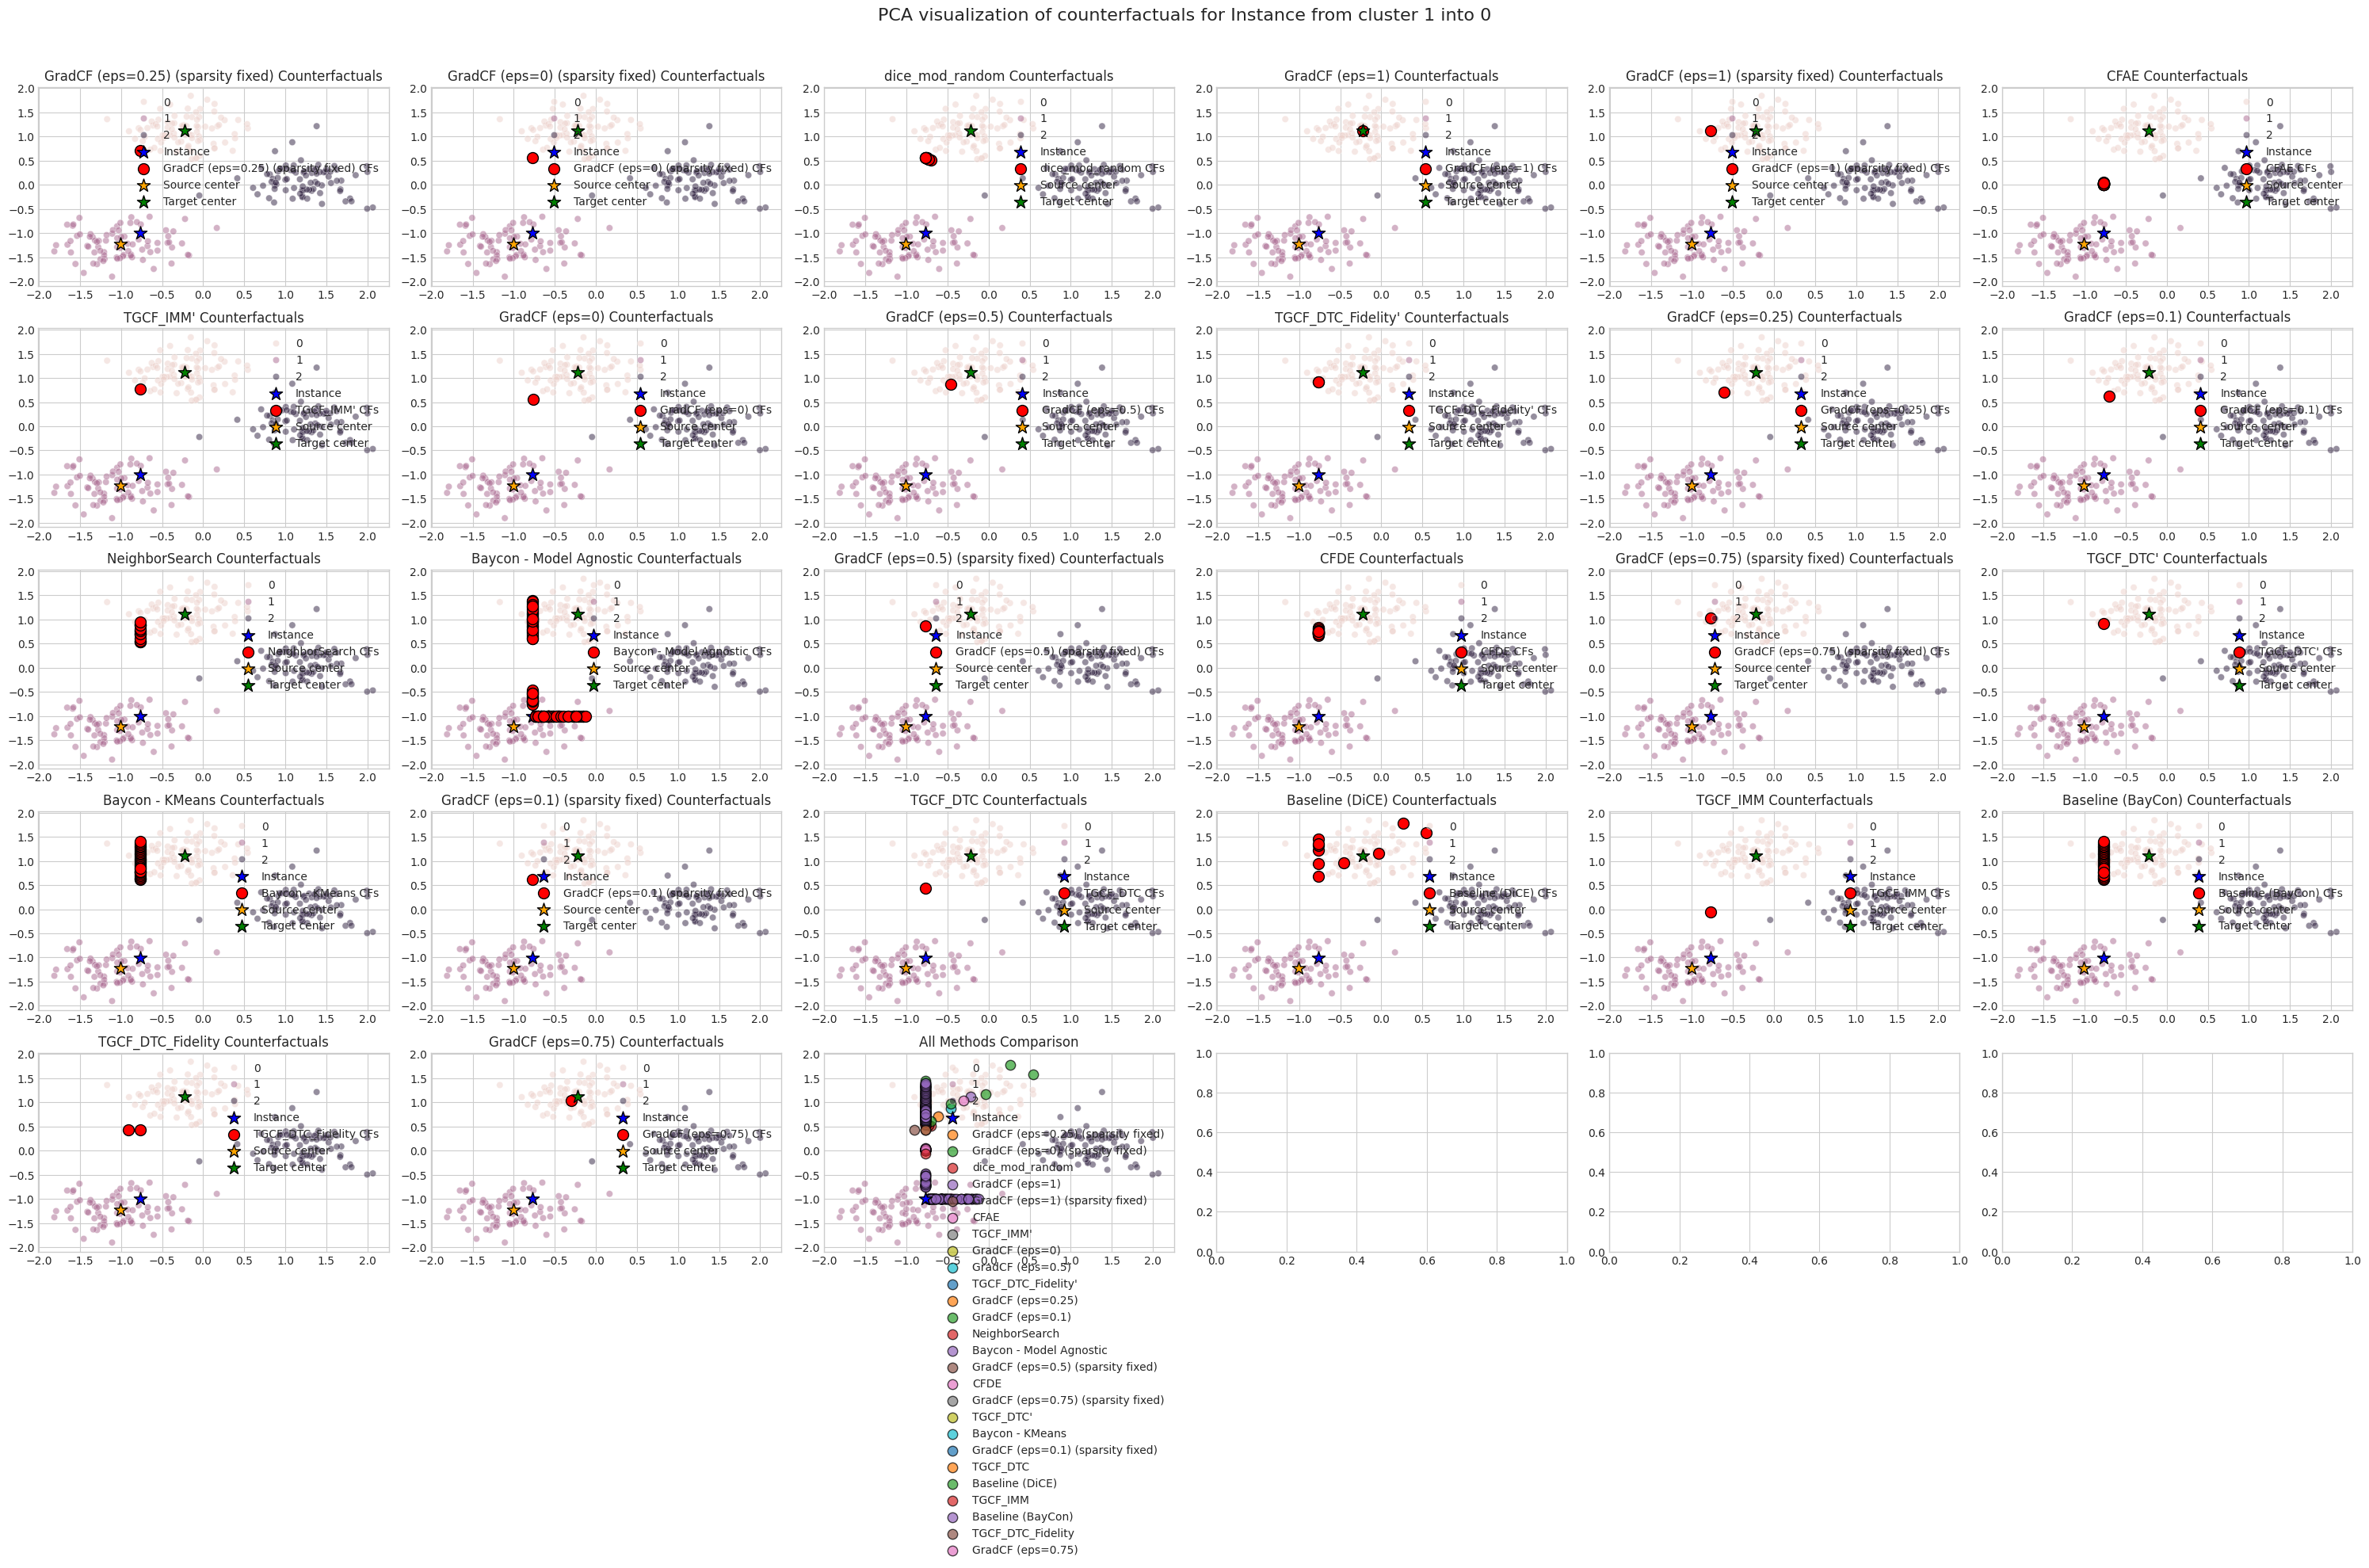

In [12]:
cf_n = 2

# Calculate the number of methods to determine grid size
n_methods = len(methods)
# Create a square-ish grid with enough cells for all methods plus one for comparison
rows = int(np.ceil(np.sqrt((n_methods + 1) / 1.5)))
cols = int(np.ceil((n_methods + 1) / rows))
fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axs = axs.flatten()

cffDict = methods

ins_c = cffDict[0]['counterfactuals'][cf_n].instance_label
target_c = cffDict[0]['counterfactuals'][cf_n].target

if X.shape[1] > 2:
    instance_embedded = pca.transform(X[[cffDict[0]['counterfactuals'][cf_n].instance]])
    methods_embedded = [
        (m['name'], pca.transform(m['counterfactuals'][cf_n].cf)) 
        for m in methods
    ]
    centers_embedded = pca.transform(centers)
else:
    instance_embedded = X[[cffDict[0]['counterfactuals'][cf_n].instance]]
    methods_embedded = [
        (m['name'], np.array(m['counterfactuals'][cf_n].cf)) 
        for m in methods
    ]
    centers_embedded = centers

# Base scatterplot of the data

for i, (name, embed) in enumerate(methods_embedded):
    sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[i])
    axs[i].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
                  marker='*', label='Instance', zorder=5, edgecolor='black')
    axs[i].scatter(embed[:, 0], embed[:, 1], color='red', s=100, 
                 marker='o', label=f'{name} CFs', zorder=5, edgecolor='black')
    axs[i].scatter(centers_embedded[ins_c,0], centers_embedded[ins_c, 1], color='orange', s=150, 
                  marker='*', label='Source center', zorder=5, edgecolor='black')
    axs[i].scatter(centers_embedded[target_c,0], centers_embedded[target_c, 1], color='green', s=150, 
                  marker='*', label='Target center', zorder=5, edgecolor='black')
    
    axs[i].set_title(f"{name} Counterfactuals")
    axs[i].legend(loc='upper right')

# Add a global title
fig.suptitle(f"PCA visualization of counterfactuals for Instance from cluster {ins_c} into {int(target_c)}", 
            fontsize=16, y=0.98)

# Final subplot for combined view
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[len(methods_embedded)])
axs[len(methods_embedded)].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
              marker='*', label='Instance', zorder=5, edgecolor='black')

# Add all counterfactuals with different markers
for i, (name, embed) in enumerate(methods_embedded):
    axs[len(methods_embedded)].scatter(embed[:, 0], embed[:, 1], label=name, s=80, 
                 alpha=0.7, edgecolor='black')
axs[len(methods_embedded)].set_title("All Methods Comparison")
axs[len(methods_embedded)].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()